In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
def preprocess_image(image, target_size=(416, 416)):
    original_h, original_w = image.shape[:2]
    target_w, target_h = target_size

    # Resize
    image = cv2.resize(image, (target_w, target_h))

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # Optional: Light Sharpen
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    # Normalize
    image = image / 255.0

    return image, (original_w, original_h)

In [5]:
def adjust_boxes(boxes, original_size, target_size=(416, 416)):
    original_w, original_h = original_size
    target_w, target_h = target_size

    new_boxes = []
    for box in boxes:
        x1, y1, x2, y2, cls = box
        x1 = int(x1 * target_w / original_w)
        y1 = int(y1 * target_h / original_h)
        x2 = int(x2 * target_w / original_w)
        y2 = int(y2 * target_h / original_h)
        new_boxes.append([x1, y1, x2, y2, cls])
    
    return new_boxes


In [6]:
def plot_original_and_preprocessed_images(image_list, boxes_list, preprocessed_images, preprocessed_boxes_list, num_images=4):
    plt.figure(figsize=(15, 8))  # Adjust the figure size to fit your images better
    for i in range(num_images):
        # Original image with boxes
        plt.subplot(2, 4, i+1)
        image = image_list[i]
        boxes = boxes_list[i]
        
        plt.imshow(image)
        for box in boxes:
            x1, y1, x2, y2, cls = box
            plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                                  edgecolor='red', facecolor='none', linewidth=2))
            plt.text(x1, y1 - 5, str(cls), color='red', fontsize=8)
        plt.title("Original Image")
        plt.axis('off')
        
        # Preprocessed image with boxes
        plt.subplot(2, 4, i+5)
        pre_img = preprocessed_images[i]
        pre_boxes = preprocessed_boxes_list[i]
        
        plt.imshow(pre_img.squeeze(), cmap='gray')  # Display grayscale image
        for box in pre_boxes:
            x1, y1, x2, y2, cls = box
            plt.gca().add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                                  edgecolor='red', facecolor='none', linewidth=2))
            plt.text(x1, y1 - 5, str(cls), color='red', fontsize=8)
        plt.title("Preprocessed Image")
        plt.axis('off')

    # Adjust the layout to minimize gaps
    plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)  # Adjust padding values
    plt.show()


In [7]:
# Paths
image_folder = "../data/train/images"
label_folder = "../data/train/labels"

all_images = os.listdir(image_folder)
random_images = random.sample(all_images, 6)

images = []
boxes = []

In [8]:
for img_name in random_images:
    img_path = os.path.join(image_folder, img_name)
    label_path = os.path.join(label_folder, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    
    # Load image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load boxes
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                if width == 0 or height == 0:
                    continue
                x_center *= image.shape[1]
                y_center *= image.shape[0]
                width *= image.shape[1]
                height *= image.shape[0]
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                bboxes.append([x1, y1, x2, y2, int(cls)])
    
    images.append(image)
    boxes.append(bboxes)

preprocessed_images = []
preprocessed_boxes = []

for img, box in zip(images, boxes):
    pre_img, original_size = preprocess_image(img)
    pre_box = adjust_boxes(box, original_size)
    
    preprocessed_images.append(pre_img)
    preprocessed_boxes.append(pre_box)

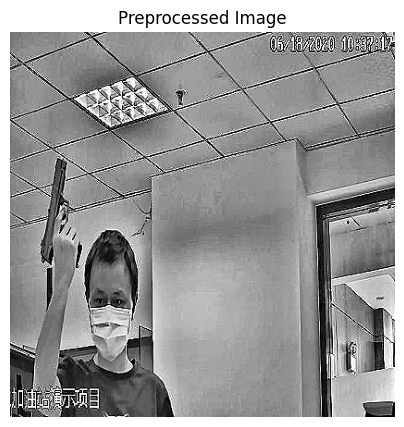

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(preprocessed_images[0].squeeze(), cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()


# Testing

In [10]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.data_loader import load_image_and_boxes,plot_multiple_images
#from src.preprocess import preprocess_image, adjust_boxes

In [11]:
# Paths to images and labels
image_folder = "../data/train/images"
label_folder = "../data/train/labels"

# Set number of images to 4
num_images = 4

# Randomly select 4 images
random_images = random.sample(all_images, num_images)

In [12]:
# Load images, preprocess them, and store results
image_list = []
boxes_list = []
preprocessed_images = []
preprocessed_boxes_list = []

In [13]:
for img_name in random_images:
    img_path = os.path.join(image_folder, img_name)
    label_path = os.path.join(label_folder, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    
    # Load original image and bounding boxes
    image, boxes = load_image_and_boxes(img_path, label_path)
    
    # Preprocess the image and adjust bounding boxes
    pre_img, original_size = preprocess_image(image)
    pre_boxes = adjust_boxes(boxes, original_size)
    
    image_list.append(image)
    boxes_list.append(boxes)
    preprocessed_images.append(pre_img)
    preprocessed_boxes_list.append(pre_boxes)

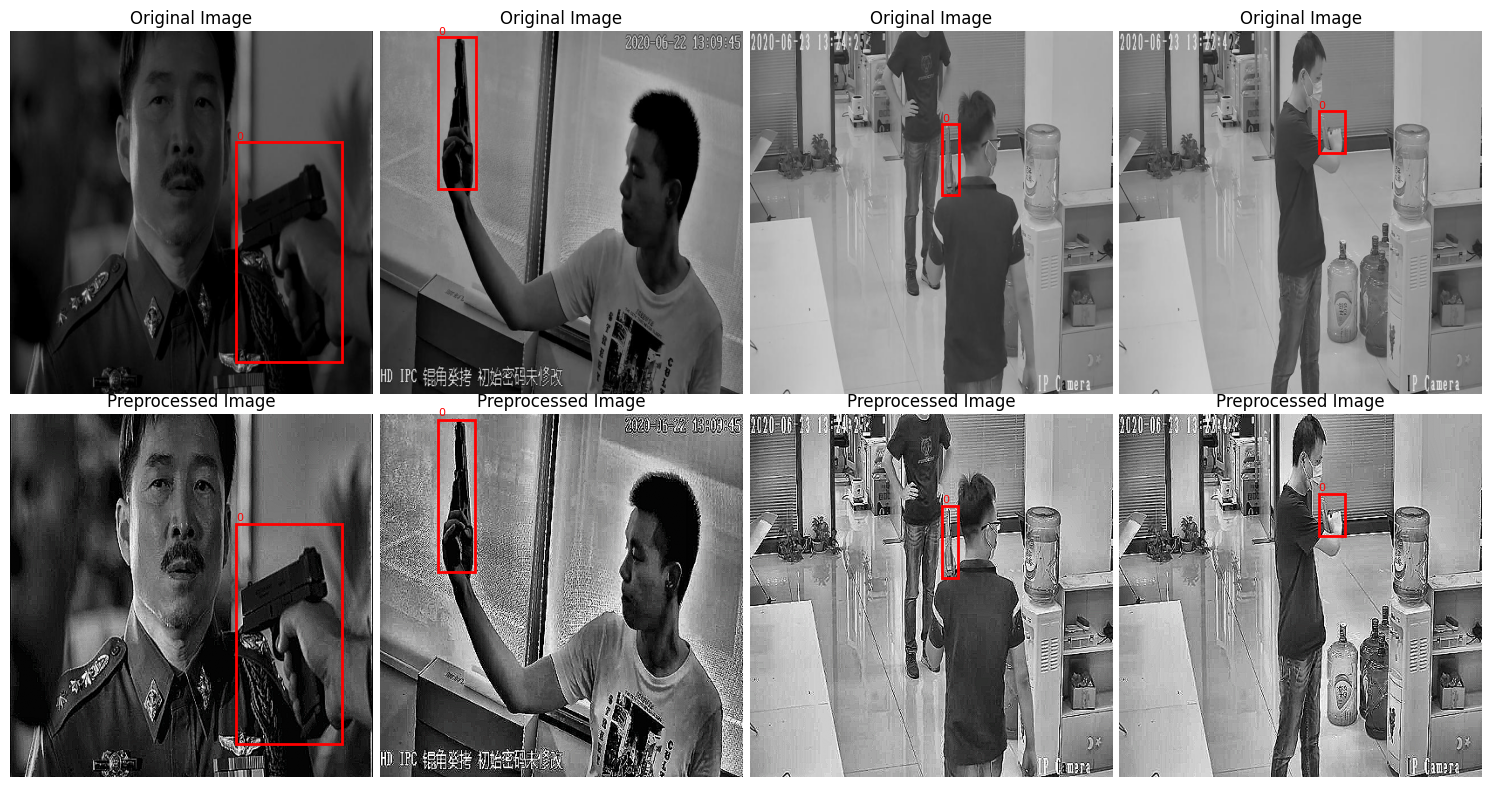

In [14]:
# Call the function to display 4 original and preprocessed images
plot_original_and_preprocessed_images(image_list, boxes_list, preprocessed_images, preprocessed_boxes_list, num_images)